# EDA (Sptial Anomaly Detection)

In [1]:
import math
import datetime
import numpy as np
import pandas as pd

import scipy.fftpack
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
sns.set(style="whitegrid")

## The data

### Load the preprocessed data

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# cd 'gdrive/My Drive/Colab Notebooks/aiforsea'

In [4]:
df = pd.read_csv('full_data.csv')
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude
0,qp09du,1,0.000000,False,1,0,0,1900-01-01 00:00:00,-5.336609,90.829468
1,qp09jm,1,0.000000,False,1,0,0,1900-01-01 00:00:00,-5.419006,90.939331
2,qp09sf,1,0.000000,False,1,0,0,1900-01-01 00:00:00,-5.347595,90.917358
3,qp09vd,1,0.000000,False,1,0,0,1900-01-01 00:00:00,-5.303650,90.950317
4,qp03y4,1,0.002732,True,1,0,0,1900-01-01 00:00:00,-5.303650,90.620728


### Collect information for each location

In [5]:
locations = df['geohash6'].unique()
print(len(locations), locations)

1329 ['qp09du' 'qp09jm' 'qp09sf' ... 'qp03wm' 'qp03jy' 'qp0999']


In [6]:
df_locinfo = pd.DataFrame()
df_locinfo['median'] = df.groupby(['geohash6'])['demand'].median()
df_locinfo['mean'] = df.groupby(['geohash6'])['demand'].mean()
df_locinfo['count'] = df.groupby(['geohash6'])['demand'].count()

df_locinfo = df_locinfo.sort_values(by=['mean', 'median'])

In [7]:
df_locinfo.iloc[int(0.95*len(locations))]
# df_locinfo.iloc[len(locations)//2:len(locations)//2+5]
#df_locinfo.head()

median       0.245194
mean         0.237392
count     5856.000000
Name: qp096w, dtype: float64

## Calculate Mahalanobis Distance

### Do FFT for each location

In [8]:
%%time
gb = df.groupby('geohash6')    
series = {}
means = {}
for x in gb.groups:
  group = gb.get_group(x)
  group = group.reset_index().drop('index', axis=1)
  means[x] = group['demand'].mean()
  group['detrended'] = group['demand'] - means[x]
  series[x] = group

Wall time: 21.8 s


In [9]:
series['qp096w'].head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude,detrended
0,qp096w,1,0.111303,True,1,0,0,1900-01-01 00:00:00,-5.369568,90.818481,-0.126089
1,qp096w,1,0.133610,True,1,0,15,1900-01-01 00:15:00,-5.369568,90.818481,-0.103781
2,qp096w,1,0.148823,True,1,0,30,1900-01-01 00:30:00,-5.369568,90.818481,-0.088568
3,qp096w,1,0.204948,True,1,0,45,1900-01-01 00:45:00,-5.369568,90.818481,-0.032443
4,qp096w,1,0.194413,True,1,1,0,1900-01-01 01:00:00,-5.369568,90.818481,-0.042979


In [10]:
freqs = []
location_encoded = {}
for location in locations:
  location_encoded[location] = len(freqs)
  freqs.append(scipy.fftpack.rfft(series[location]['detrended'])[:1000])
freqs = np.asarray(freqs)

### Reduce dimensionality

In [11]:
pca = PCA(n_components=0.95)
freqs_reduced = pca.fit_transform(freqs)
freqs_reduced.shape

(1329, 41)

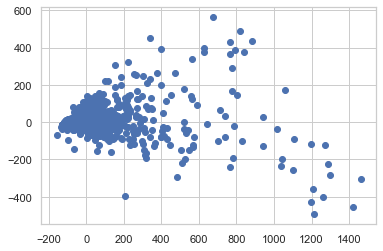

In [12]:
plt.scatter(freqs_reduced[:,0], freqs_reduced[:,1])

### Calculate Mahalanobis Distance

In [13]:
mu = freqs_reduced.mean(axis=0)
mu = mu.reshape(1, -1)
print(mu.shape)

(1, 41)


In [14]:
std = freqs_reduced.std(axis=0)
std = std.reshape(1, -1)
print(std.shape)

(1, 41)


In [15]:
mahalanobis_dist = (((freqs_reduced - mu)/std)**2).sum(axis=1)**(0.5)
mahalanobis_dist.shape

(1329,)

### Inspect

In [16]:
print(mahalanobis_dist.max())
print(np.where(mahalanobis_dist == mahalanobis_dist.max()))

34.42829847494084
(array([840], dtype=int64),)


In [17]:
print(mahalanobis_dist.min())
print(np.where(mahalanobis_dist == mahalanobis_dist.min()))

0.7834854511566796
(array([1273], dtype=int64),)


(array([968., 180.,  70.,  37.,  24.,  18.,  12.,  13.,   5.,   2.]),
 array([ 0.78348545,  4.14796675,  7.51244806, 10.87692936, 14.24141066,
        17.60589196, 20.97037327, 24.33485457, 27.69933587, 31.06381717,
        34.42829847]),
 <a list of 10 Patch objects>)

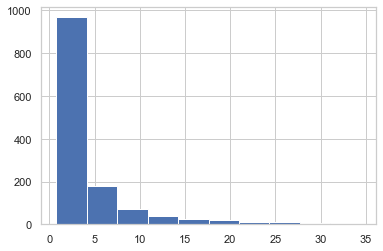

In [18]:
plt.hist(mahalanobis_dist)

### Plots

qp03xd


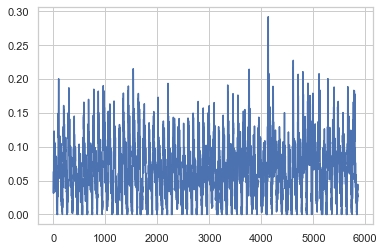

In [19]:
print(locations[1046])
plt.plot(series[locations[1046]]['demand'])

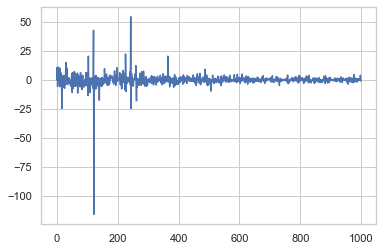

In [20]:
plt.plot(freqs[1046])

qp09gh


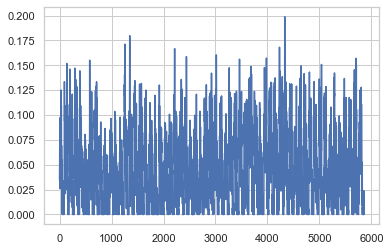

In [21]:
print(locations[979])
plt.plot(series[locations[979]]['demand'])

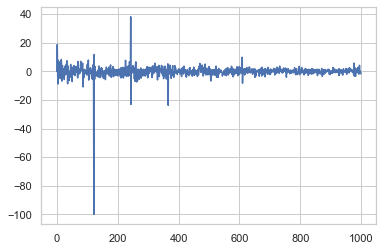

In [22]:
plt.plot(freqs[979])

### Save

In [23]:
np.save('freq_mahalanobis_dist.npy', mahalanobis_dist)